**LABELLING AND CLASSIFICATION USING BERT MODEL**

Apply text classification to detect which generator was used to create the audio.

The code represent the pipeline for text classification using fine-tuned BERT model.

Here, we consider only 6 classes of the total 7. SunoCaps in this case, since it is unbalanced respect to the other classes, is not considered. We take into consideration only the 6 classes with 2500 files each.

In this code we are doing a closed-set classification: we have the same number of classes (no unseen classes) both in training and in testing.


In [1]:
# Connection to Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing all the necessary libraries.
import os
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

In [6]:
# Loading and initial preparation of the data.
base_path = "/content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500"

data = []

for label in os.listdir(base_path):
    if label == "SunoCaps":
        continue  # skip this folder for closed set case
    label_path = os.path.join(base_path, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.endswith(".json"):
                file_path = os.path.join(label_path, file)
                try:
                    with open(file_path, 'r') as f:
                        json_data = json.load(f)
                        caption_data = json_data.get('0', {})
                        caption = caption_data.get("text", "")
                        if caption:
                            data.append({"text": caption, "label": label})
                except Exception as e:
                    print(f"Errore in {file_path}: {e}")

# Transform the list of dictionaries to DataFrames.
df = pd.DataFrame(data)
print(df.head())

# Where to save the CSV.
output_path = "/content/drive/MyDrive/L02CapstoneProject/LabelledData.csv"

# Saving only the column text and label.
df[['text', 'label']].to_csv(output_path, index=False)

print(f"File saved in: {output_path}")

Errore in /content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500/MusicGen_medium/mWuX--EEq2E_captions.json: Expecting value: line 1 column 1 (char 0)
                                                text     label
0  The low quality recording features a live perf...  musicldm
1  This music is an animated instrumental. The te...  musicldm
2  The low quality recording features a live perf...  musicldm
3  The low quality recording features a techno so...  musicldm
4  The low quality recording features a live perf...  musicldm
File saved in: /content/drive/MyDrive/L02CapstoneProject/LabelledData.csv


In [7]:
# Division of the dataset and label's encoding.

# Train, test, validation split.
df_train_val, df_test = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=0.2, stratify=df_train_val["label"], random_state=42)

# Visualization.
print(f"Train set: {len(df_train)} samples")
print(f"Validation set: {len(df_val)} samples")
print(f"Test set: {len(df_test)} samples")

print("\nDistribution of the labels on the training set:")
print(df_train['label'].value_counts())

print("\nDistribution of the labels on the validation set:")
print(df_val['label'].value_counts())

print("\nDistribution of the labels on the test set:")
print(df_test['label'].value_counts())


Train set: 8393 samples
Validation set: 2099 samples
Test set: 4497 samples

Distribution of the labels on the training set:
label
mustango             1400
MusicCaps            1400
musicldm             1400
audioldm2            1400
MusicGen_medium      1399
stable_audio_open    1394
Name: count, dtype: int64

Distribution of the labels on the validation set:
label
mustango             350
MusicGen_medium      350
audioldm2            350
musicldm             350
MusicCaps            350
stable_audio_open    349
Name: count, dtype: int64

Distribution of the labels on the test set:
label
musicldm             750
mustango             750
MusicCaps            750
audioldm2            750
MusicGen_medium      750
stable_audio_open    747
Name: count, dtype: int64


In [8]:
# Map textual labels to numeric labels.
label2id = {label: idx for idx, label in enumerate(df["label"].unique())}
id2label = {idx: label for label, idx in label2id.items()}

# Maps the DataFrames.
df_train["label"] = df_train["label"].map(label2id)
df_val["label"] = df_val["label"].map(label2id)
df_test["label"] = df_test["label"].map(label2id)


In [9]:
# Tokenization and Creation of the DataLoader.

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function.
def tokenize_data(sentences, labels, max_len=128): # fare prova con 128. Se non migliora tornare a 64.
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Transformation in tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
# Tokenization of the data.
train_inputs, train_masks, train_labels = tokenize_data(df_train["text"].values, df_train["label"].values)
val_inputs, val_masks, val_labels = tokenize_data(df_val["text"].values, df_val["label"].values)
test_inputs, test_masks, test_labels = tokenize_data(df_test["text"].values, df_test["label"].values)

In [12]:
# Batch size
batch_size = 16

# Creation of the TensorDataset.
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

# Creation of the DataLoader.
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)


In [13]:
# Model configuration and training configuration.

num_labels = len(df["label"].unique()) # Dynamic usage of the labels.


# Loading Bert Model.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False,
)

# Move to GPU if possible.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
# Definition of the optimizer.
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Number of training steps.
epochs = 20
total_steps = len(train_dataloader) * epochs

# Scheduler to deal with the learning rate during the training.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [17]:
# Utility function and evaluation.

def format_time(elapsed):
    return str(time.strftime("%H:%M:%S", time.gmtime(elapsed)))

# Evaluation function.
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    for batch in dataloader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc, all_labels, all_preds

train_losses = []

In [18]:
# Training loop.

import random # Import the random module

seed_val = 42
torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)

for epoch_i in range(epochs):
    print(f'\n======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        model.zero_grad()

        outputs = model(
            b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()


    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    training_time = format_time(time.time() - t0)

    print(f"\nAverage training loss: {avg_train_loss:.2f}")
    print(f"Training epoch took: {training_time}")

    print("\nRunning Validation...")
    val_accuracy, val_labels, val_preds = evaluate(model, validation_dataloader)
    print(f"Validation Accuracy: {val_accuracy:.2f}")


======== Epoch 1 / 20 ========
Training...

Average training loss: 1.71
Training epoch took: 00:02:58

Running Validation...
Validation Accuracy: 0.32

======== Epoch 2 / 20 ========
Training...

Average training loss: 1.55
Training epoch took: 00:03:01

Running Validation...
Validation Accuracy: 0.38

======== Epoch 3 / 20 ========
Training...

Average training loss: 1.42
Training epoch took: 00:03:01

Running Validation...
Validation Accuracy: 0.39

======== Epoch 4 / 20 ========
Training...

Average training loss: 1.29
Training epoch took: 00:03:01

Running Validation...
Validation Accuracy: 0.41

======== Epoch 5 / 20 ========
Training...

Average training loss: 1.17
Training epoch took: 00:03:01

Running Validation...
Validation Accuracy: 0.41

======== Epoch 6 / 20 ========
Training...

Average training loss: 1.05
Training epoch took: 00:03:01

Running Validation...
Validation Accuracy: 0.40

======== Epoch 7 / 20 ========
Training...

Average training loss: 0.95
Training epoch 

In [ ]:
# Final evaluation on the test set.
print("\nRunning Final Test Evaluation...")
test_accuracy, test_labels, test_preds = evaluate(model, test_dataloader)
print(f"Test Accuracy: {test_accuracy:.2f}")


Running Final Test Evaluation...
Test Accuracy: 0.40


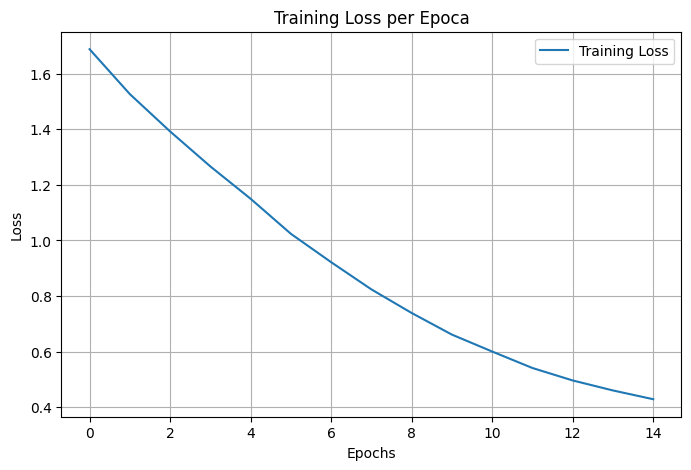


📋 Classification Report:
                    precision    recall  f1-score   support

         musicldm       0.36      0.37      0.36       750
  MusicGen_medium       0.38      0.41      0.39       750
stable_audio_open       0.45      0.46      0.45       747
        MusicCaps       0.47      0.28      0.35       750
         mustango       0.39      0.43      0.41       750
        audioldm2       0.40      0.48      0.44       750

         accuracy                           0.40      4497
        macro avg       0.41      0.40      0.40      4497
     weighted avg       0.41      0.40      0.40      4497



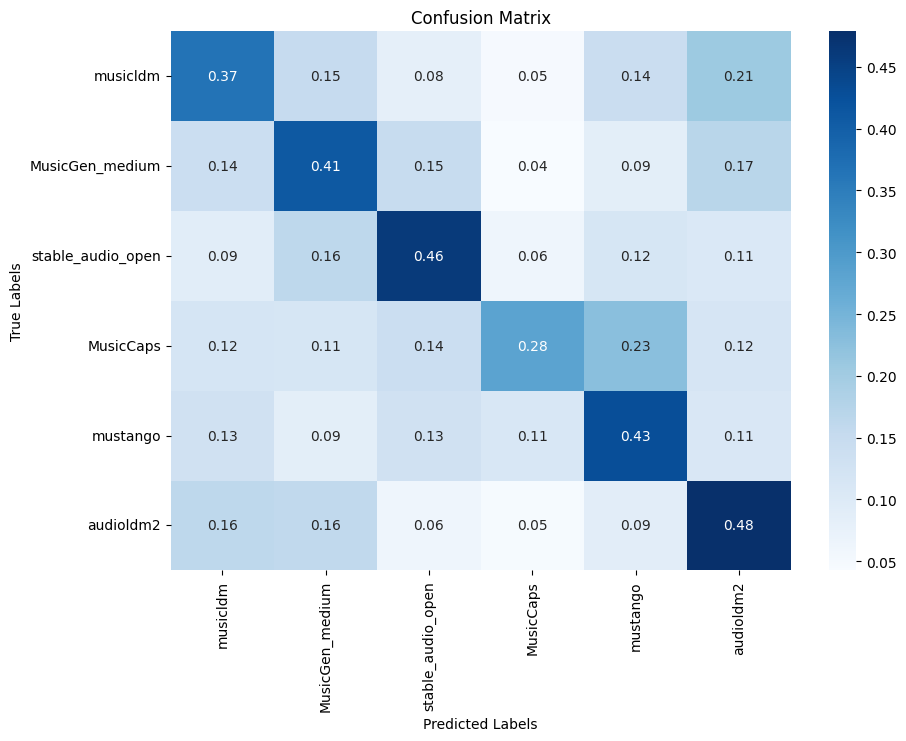

In [ ]:

# Visualization of the loss plot.
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoca')
plt.legend()
plt.grid(True)
plt.show()


classification_label_names = [id2label[i] for i in range(num_labels)] # Define right ordering for the labels.
print("\n📋 Classification Report:\n", classification_report(test_labels, test_preds, target_names=classification_label_names))


# Labels must be passed to have the right order.
cm = confusion_matrix(test_labels, test_preds, labels=list(label2id.values())) # Usa i valori numerici degli ID

# Normalization of the confusion matrix.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classification_label_names,
            yticklabels=classification_label_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the model and inference.
output_dir = "/content/drive/MyDrive/L02CapstoneProject/BERT_output_model"

# Create the folder/file if it does not exist.
os.makedirs(output_dir, exist_ok=True)

# Saving the model.
model.save_pretrained(output_dir)

# Saving the tokenizer.
tokenizer.save_pretrained(output_dir)

print(f"Modello e tokenizer salvati in: {output_dir}")


Modello e tokenizer salvati in: /content/drive/MyDrive/L02CapstoneProject/BERT_output_model


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the model.
model_path = "/content/drive/MyDrive/L02CapstoneProject/BERT_output_model"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)
model.to(device)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Example of usage.

# Function to predict a single caption.
def predict_caption(caption_text, model, tokenizer):
    model.eval()

    inputs = tokenizer.encode_plus(
        caption_text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits


        prediction_id = torch.argmax(logits, dim=1).item()

        return prediction_id, id2label[prediction_id]

sample_text = "This is a live performance of a jazz music piece. It is an instrumental piece. There is a trumpet and a saxophone playing a solo in the lead. The bass guitar is playing a groovy solo. The rhythmic background is provided by the acoustic drums. The atmosphere is upbeat. This piece could be sampled for use in beat-making."
prediction_id, predicted_label_name = predict_caption(sample_text, model, tokenizer)
print(f"\nPredicted Label from: {predicted_label_name} (ID: {prediction_id})")




Predicted Label from: musicldm (ID: 0)
